In [1]:
from model import UNET
from utils import load_checkpoint
import torch

import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
model = UNET()
model.to(device=device)

load_checkpoint(checkpoint=torch.load('C:/Users/mrxyz/Documents/MYProject/YndSpecProject/Experiments/Segmentator/Checkpoints/my_checkpoint5.pth.tar', map_location=device), model=model)

=> Loading checkpoint


In [10]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform is not None:
            image = self.transform(image=image)

        return image

In [11]:
transform = A.Compose([
    # transforms.ToTensor(),
    A.Normalize(
    mean=[0.0, 0.0, 0.0],
    std=[1.0, 1.0, 1.0],
    max_pixel_value=255.0,
    ),
    ToTensorV2()
])

test_dataset = CarvanaDataset(image_dir='C:/Users/mrxyz/Documents/MYProject/YndSpecProject/data/train_images', transform=transform)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

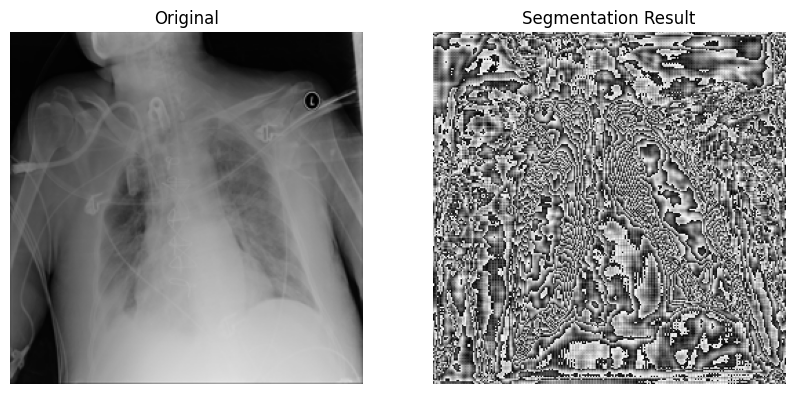

In [14]:
model.eval()

with torch.no_grad():
    inputs = test_dataset[2]['image'].unsqueeze(0).to(device)
    outputs = model(inputs)

    # Визуализация
    input_img = transforms.ToPILImage()(inputs.squeeze())
    output_img = transforms.ToPILImage()(outputs.squeeze())
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_img)
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    axes[1].imshow(output_img, cmap='gray')
    axes[1].set_title("Segmentation Result")
    axes[1].axis("off")

    plt.show()